## 1 - Carrega informações do dataframe  
## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação  
## 3 - gera o corpus (bag of words) e vetoriza  
## 4 - Faz a transformação TFIDF  
## 5 - Cria bases de treinamento e validação  
## 6 - Cria modelo  
## 7 - Analisa a acurária e a perda de cada modelo  
## 8 - Cria predições para cada modelo treinado  
## 9 - Aplica o modelo na base completa e analisa resultados  

In [1]:
import pandas as pd
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from collections import namedtuple
from typing import Dict


## 1 - Carrega informações do dataframe

### 1.1 - dados de descrição limpa (com stopwords e com afixos)

In [2]:
df_itens = pd.read_parquet('itens_desc_limpa_sem_stopwords.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa.parquet')

In [3]:
len(df_itens), len(df_tec)

(26115, 10147)

In [4]:
df_itens[df_itens['capitulo'] == '00']

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem


In [5]:
# Duplicar linhas com somente 1 ou 2 exemplos
df_itens = df_itens.append(df_itens[df_itens['capitulo'].map(df_itens['capitulo'].value_counts()) <= 2])

In [6]:
df_itens.head()

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem
0,mascara facial hidratante embalagem 25ml days ...,33,04,99,1,0
1,dioctil ftalato flexi bag d 20 toneladas metri...,29,17,32,0,0
2,sola calcado borracha belfast mx,64,06,20,0,0
3,sola calcado borracha lyon mx,64,06,20,0,0
4,sola calcado borracha lyon mx,64,06,20,0,0


In [7]:
df_itens[df_itens['capitulo'] == '99']

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem
4441889,,99,99,99,9,9
4337496,seamer drone importado,99,99,99,9,9
4441889,,99,99,99,9,9
4337496,seamer drone importado,99,99,99,9,9


In [8]:
len(df_itens)

26117

In [9]:
# apaga linhas vazias
df_itens = df_itens.drop(df_itens[df_itens['descricao_limpa_sem_stopwords'] == ''].index)

In [10]:
len(df_itens)

26104

In [11]:
df_tec.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa
0,Reprodutores de raca pura Cavalos Cavalos as...,1012100.0,01012100,01,01,21,0,0,reprodutores de raca pura cavalos cavalos asin...
1,Outros Cavalos Cavalos asininos e muares vi...,1012900.0,01012900,01,01,29,0,0,outros cavalos cavalos asininos e muares vivos
2,Asininos Cavalos asininos e muares vivos,1013000.0,01013000,01,01,30,0,0,asininos cavalos asininos e muares vivos
3,Outros Cavalos asininos e muares vivos,1019000.0,01019000,01,01,90,0,0,outros cavalos asininos e muares vivos
4,Prenhes ou com cria ao pe Reprodutores de raca...,1022110.0,01022110,01,02,21,1,0,prenhes ou com cria ao pe reprodutores de raca...


In [12]:
df_tec = df_tec[['capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [13]:
df_tec.head()

,capitulo,posicao,subposicao,item,subitem
0,01,01,21,0,0
1,01,01,29,0,0
2,01,01,30,0,0
3,01,01,90,0,0
4,01,02,21,1,0


## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação.

In [14]:
Encoders = namedtuple('Encoders', 'encoder binarizer')

def encode_fields(df, fields: list) -> Dict[str, Encoders]:
    result = {}
    for i, field in enumerate(fields):
        lblencoder = LabelEncoder()  # cria um número para cada categoria
        lblbinarizer = LabelBinarizer()  # one hot encoder (ex: 99categorias cria matriz com 99 intens com 0 e 1)
        encoded = lblencoder.fit_transform(df[field].values)  # transforma os dados do array "field" em classes
        # dessa forma, retorna um array com as categorias na forma numérica, começando em zero
        print(f'field: {field} / encoded shape: {encoded.shape}')
        binarized = lblbinarizer.fit_transform(encoded)  # transforma os dados do array "field" numa matriz com 
        # dados binários (zeros e uns) para cada categoria, então retorna matriz m x n, onde m é a quantidade 
        # de linhas do array de entrada e n é a quantidade de colunas de categorias tranformadas em sua 
        # forma binária 
        print(f'field: {field} / binarized shape: {binarized.shape}')
        encoders = Encoders(lblencoder, lblbinarizer)
        result[field] = encoders
    return result

In [15]:
encoders = encode_fields(df_itens, ['capitulo', 'posicao', 'subposicao', 'item', 'subitem'])

field: capitulo / encoded shape: (26104,)
field: capitulo / binarized shape: (26104, 97)
field: posicao / encoded shape: (26104,)
field: posicao / binarized shape: (26104, 90)
field: subposicao / encoded shape: (26104,)
field: subposicao / binarized shape: (26104, 91)
field: item / encoded shape: (26104,)
field: item / binarized shape: (26104, 10)
field: subitem / encoded shape: (26104,)
field: subitem / binarized shape: (26104, 10)


### 2.1 - encode da coluna "capítulo"

In [17]:
y_encoded_cap = encoders['capitulo'].encoder.transform(df_itens.capitulo.values)
y_encoded_pos = encoders['posicao'].encoder.transform(df_itens.posicao.values)
y_encoded_subpos = encoders['subposicao'].encoder.transform(df_itens.subposicao.values)
y_encoded_item = encoders['item'].encoder.transform(df_itens.item.values)
y_encoded_subitem = encoders['subitem'].encoder.transform(df_itens.subitem.values)

In [18]:
print(f'formato do array "y_encoded_cap": {y_encoded_cap.shape} linhas, \nconteúdo: \n{y_encoded_cap}')
print(f'formato do array "y_encoded_pos": {y_encoded_pos.shape} linhas, \nconteúdo: \n{y_encoded_pos}')
print(f'formato do array "y_encoded_subpos": {y_encoded_subpos.shape} linhas, \nconteúdo: \n{y_encoded_subpos}')
print(f'formato do array "y_encoded_item": {y_encoded_item.shape} linhas, \nconteúdo: \n{y_encoded_item}')
print(f'formato do array "y_encoded_subitem": {y_encoded_subitem.shape} linhas, \nconteúdo: \n{y_encoded_subitem}')



formato do array "y_encoded_cap": (26104,) linhas, 
conteúdo: 
[32 28 63 ... 83 83 96]
formato do array "y_encoded_pos": (26104,) linhas, 
conteúdo: 
[ 3 16  5 ... 26 27 89]
formato do array "y_encoded_subpos": (26104,) linhas, 
conteúdo: 
[90 23 11 ... 12 62 90]
formato do array "y_encoded_item": (26104,) linhas, 
conteúdo: 
[1 0 0 ... 0 9 9]
formato do array "y_encoded_subitem": (26104,) linhas, 
conteúdo: 
[0 0 0 ... 0 0 9]


### 2.2 - encode binário da coluna "capítulo" - gera matriz

In [19]:
y_cap = encoders['capitulo'].binarizer.fit_transform(y_encoded_cap)
y_pos = encoders['posicao'].binarizer.fit_transform(y_encoded_pos)
y_subpos = encoders['subposicao'].binarizer.fit_transform(y_encoded_subpos)
y_item = encoders['item'].binarizer.fit_transform(y_encoded_item)
y_subitem = encoders['subitem'].binarizer.fit_transform(y_encoded_subitem)
y_todos = [y_cap, y_pos, y_subpos, y_item, y_subitem]

In [20]:
print(f'formato da matriz "y_cap": {y_cap.shape} (linhas, colunas),\nconteúdo: \n{y_cap}')
print(f'formato da matriz "y_pos": {y_pos.shape} (linhas, colunas),\nconteúdo: \n{y_pos}')
print(f'formato da matriz "y_subpos": {y_subpos.shape} (linhas, colunas),\nconteúdo: \n{y_subpos}')
print(f'formato da matriz "y_item": {y_item.shape} (linhas, colunas),\nconteúdo: \n{y_item}')
print(f'formato da matriz "y_subitem": {y_subitem.shape} (linhas, colunas),\nconteúdo: \n{y_subitem}')

formato da matriz "y_cap": (26104, 97) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_pos": (26104, 90) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subpos": (26104, 91) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_item": (26104, 10) (linhas, colunas),
conteúdo: 
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subitem": (26104, 10) (linhas, colunas),
conteúdo: 
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


## 3 - gera o corpus (bag of words) e vetoriza 

In [21]:
corpus = df_itens.descricao_limpa_sem_stopwords.values  # transforma todo o texto em bag of words
vectorizer = CountVectorizer(max_df=0.1, min_df=0.00001)  # elimina palavras mto ou pouco frequentes
X_counts = vectorizer.fit_transform(corpus)  # aprende o dicionário de vocabulários e gera matriz 
X_counts.shape

(26104, 23561)

In [22]:
X_pos = y_pos
X_pos.shape

(26104, 90)

In [23]:
X_subpos = y_subpos
X_subpos.shape

(26104, 91)

In [24]:
X_item = y_item
X_item.shape

(26104, 10)

In [25]:
X_subitem = y_subitem
X_subitem.shape

(26104, 10)

#### limpa memória excluindo variável que não será mais utilizada

In [26]:
# del vectorizer
del corpus  # apaga o corpus que gerou X_counts

## 4 - Faz a transformação TFIDF - realiza o cálculo da frequência relativa das palavras multiplicando por um peso, de forma a diminuir as palavras muito frequêntes e as raras.

In [27]:
transformer = TfidfTransformer()  # transforma em matrix TFIDF - faz freq relativa multiplicando um 
# peso nas palavras freq ou raras - ou seja, deixa de ser zero e 1.
X_tf = transformer.fit_transform(X_counts)

In [28]:
X_tf.shape

(26104, 23561)

## 5 - Cria bases de treinamento e validação

### 5.1 - a base de teste representa 5% do dataset e está estratificada conforme os rótulos de "y" (matriz binária)

In [29]:
X_train_cap, X_val_cap, y_train_cap, y_val_cap = train_test_split(X_tf, y_cap, test_size=0.05, stratify=y_cap, random_state=1)

In [30]:
# não funcionou stratify
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(X_tf, y_pos, test_size=0.05, random_state=1)

In [31]:
# não funcionou stratify
X_train_subpos, X_val_subpos, y_train_subpos, y_val_subpos = train_test_split(X_tf, y_subpos, test_size=0.05, random_state=1)

In [32]:
X_train_item, X_val_item, y_train_item, y_val_item = train_test_split(X_tf, y_item, test_size=0.05, stratify=y_item, random_state=1)

In [33]:
X_train_subitem, X_val_subitem, y_train_subitem, y_val_subitem = train_test_split(X_tf, y_subitem, test_size=0.05, stratify=y_subitem, random_state=1)

In [34]:
X_train_todos = [X_train_cap, X_train_pos, X_train_subpos, X_train_item, X_train_subitem]
X_val_todos = [X_val_cap, X_val_pos, X_val_subpos, X_val_item, X_val_subitem]
y_train_todos = [y_train_cap, y_train_pos, y_train_subpos, y_train_item, y_train_subitem]
y_val_todos = [y_val_cap, y_val_pos, y_val_subpos, y_val_item, y_val_subitem]

In [35]:
for X_train in X_train_todos:
    print(f'Treinando com {X_train.shape[0]} exemplos da base e {X_train.shape} palavras diferentes')

Treinando com 24798 exemplos da base e (24798, 23561) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 23561) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 23561) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 23561) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 23561) palavras diferentes


In [36]:
for X_val in X_val_todos:
    print(f'Validando com {X_val.shape[0]} exemplos da base e {X_val.shape} palavras diferentes')

Validando com 1306 exemplos da base e (1306, 23561) palavras diferentes
Validando com 1306 exemplos da base e (1306, 23561) palavras diferentes
Validando com 1306 exemplos da base e (1306, 23561) palavras diferentes
Validando com 1306 exemplos da base e (1306, 23561) palavras diferentes
Validando com 1306 exemplos da base e (1306, 23561) palavras diferentes


In [37]:
for y_train in y_train_todos:
    print(f'y_train com {y_train.shape[0]} exemplos da base e {y_train.shape} palavras diferentes')

y_train com 24798 exemplos da base e (24798, 97) palavras diferentes
y_train com 24798 exemplos da base e (24798, 90) palavras diferentes
y_train com 24798 exemplos da base e (24798, 91) palavras diferentes
y_train com 24798 exemplos da base e (24798, 10) palavras diferentes
y_train com 24798 exemplos da base e (24798, 10) palavras diferentes


In [38]:
for y_val in y_val_todos:
    print(f'y_val com {y_val.shape[0]} exemplos da base e {y_val.shape} palavras diferentes')

y_val com 1306 exemplos da base e (1306, 97) palavras diferentes
y_val com 1306 exemplos da base e (1306, 90) palavras diferentes
y_val com 1306 exemplos da base e (1306, 91) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes


In [39]:
# cria dicionário com todos os modelos por coluna
setups = {}
colunas = ['cap', 'pos', 'subpos', 'item', 'subitem']
for i, coluna in enumerate(colunas):
    setups[coluna] = [X_train_todos[i], X_val_todos[i], y_train_todos[i], y_val_todos[i]]

In [40]:
#### limpa memória excluindo variavéis que não serão mais utilizadas

In [41]:
del X_tf  # apaga o resultado do TFIDF que foi utilizado para criar a base de teste e validação

In [42]:
del X_counts  # apaga o X_count que originou o X_tf
del X_pos
del X_subpos
del X_item
del X_subitem

## 6 - Cria modelo

### 6.1 - Cria modelo classificador usando 2 camadas full connected (densidade passada por parâmetro 256 ou 512 neurônios e ativador "relu") com dropout passado por parâmetro sendo de 20% ou de 40%, para reduzir overfitting

#### obs: foram utilizadas 2 camadas pois com duas camadas é suficiente para identificamos relações não lineraes, mais de duas camadas teríamos que treinar o modelo muitas vezes o que tornaria mais complexo.

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def model1(input_size, output_size, optimizer='adam', dropout=0.4, dense=128):  # "adam" converge + rapido, melhor relação custo memória 
    # e tempo, é mais usado (SGD, SGD com momentum)
    model = tf.keras.Sequential()
    model.add(layers.Input(input_size))
    model.add(layers.Dense(dense, activation='relu'))  # ativador do neuronio função relu
    model.add(layers.Dropout(dropout))  # a cada passada ignora 40% dos neurônios 
    model.add(layers.Dense(dense, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_size, activation='softmax'))  # coleção de 0, 1 do sigmoide
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # pega o softmax, onde tá zero penaliza como 0,123 e onde tá 1 recompensa o neuronio
                  metrics=['accuracy'])

    return model

### 6.2 - Cria modelos com dropouts e densidades diferentes

In [44]:
# melhor configuração 256 neuronios e dropout 0.2
models = {}
dense = 256
dropout = 0.2
i = 0
for k, setup in setups.items():
    print(f'model {k}: Xtrain: {setup[0].shape[1]} e y_train: {setup[2].shape[1]} ')
    models[k] = model1(
            setup[0].shape[1], 
            setup[2].shape[1],
            optimizer=tf.keras.optimizers.Adam(lr=0.001),
            dropout=dropout, dense=dense)

model cap: Xtrain: 23561 e y_train: 97 
model pos: Xtrain: 23561 e y_train: 90 
model subpos: Xtrain: 23561 e y_train: 91 
model item: Xtrain: 23561 e y_train: 10 
model subitem: Xtrain: 23561 e y_train: 10 


### 6.3 - treina esses modelos sendo para cada modelo roda 40 epócas, dividindo a entrada em chunks de tamanho 512, para cada época e com um learning rate decrescente

In [45]:
from collections import defaultdict
import math

epochs = 40
# batch_size = 256
batch_size = 512
for key, setup in setups.items():
    rounds = setup[0].shape[0] // batch_size  +  1
    history = defaultdict(list)
    X_val_array = setup[1].toarray()
    
    print(f'\n\n modelo: {key} \n\n')
    for i in range(epochs):
        lr = 0.001 / (math.sqrt(i) + 1)
        print(f'Epoch {i} learning rate {lr}')
        K.set_value(models[key].optimizer.lr, lr)
        for batch_number in range(rounds):
            start = batch_number * batch_size
            X_chunk = setup[0][start: start + batch_size].toarray()
            y_chunk = setup[2][start: start + batch_size]
            models[key].train_on_batch(X_chunk, y_chunk)  # treina o modelo efetivamente
            if batch_number % 100 == 0.:
                print(f'Batch n.: {batch_number} de {rounds}')
                loss_acc = models[key].evaluate(X_chunk, y_chunk)
                history['train_loss'].append(loss_acc[0])
                history['train_acc'].append(loss_acc[1])
                val_loss_acc = models[key].evaluate(X_val_array, setup[3])
                history['val_loss'].append(val_loss_acc[0])
                history['val_acc'].append(val_loss_acc[1])
                # print('loss: {:0.2f} acc: {:0.2f}'.format(val_monitor[0], val_monitor[1]))
        print('##################################################')
        print(f'Final da época {i}')
        models[key].evaluate(X_chunk, y_chunk)
        models[key].evaluate(setup[1].toarray(), setup[3])
        print('##################################################')
        del X_chunk
        del y_chunk



 modelo: cap 


Epoch 0 learning rate 0.001
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 4.5653 - accuracy: 0.2282
##################################################
Final da época 0
41/41 [==============================] - 0s 7ms/step - loss: 2.1300 - accuracy: 0.4648
##################################################
Epoch 1 learning rate 0.0005
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 2.1139 - accuracy: 0.4694
##################################################
Final da época 1
41/41 [==============================] - 0s 7ms/step - loss: 1.4654 - accuracy: 0.6723
##################################################
Epoch 2 learning rate 0.00041421356237309506
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 1.4566 - accuracy: 0.6769
##################################################
Final da época 2
41/41 [==============================] - 0s 6ms/step - loss: 1.1193 - accuracy: 0.758

41/41 [==============================] - 0s 7ms/step - loss: 0.2481 - accuracy: 0.9349
##################################################
Epoch 16 learning rate 0.0002
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2480 - accuracy: 0.9349
##################################################
Final da época 16
41/41 [==============================] - 0s 6ms/step - loss: 0.2401 - accuracy: 0.9357
##################################################
Epoch 17 learning rate 0.0001951941016011038
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2398 - accuracy: 0.9342
##################################################
Final da época 17
41/41 [==============================] - 0s 6ms/step - loss: 0.2314 - accuracy: 0.9364
##################################################
Epoch 18 learning rate 0.0001907435698305462
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2311 - accuracy: 0.9364
#############

Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1965 - accuracy: 0.9464
##################################################
Final da época 31
41/41 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 0.9464
##################################################
Epoch 32 learning rate 0.00015022110482233484
Batch n.: 0 de 49
41/41 [==============================] - 0s 8ms/step - loss: 0.1948 - accuracy: 0.9449
##################################################
Final da época 32
41/41 [==============================] - 0s 7ms/step - loss: 0.1944 - accuracy: 0.9449
##################################################
Epoch 33 learning rate 0.0001482675827043134
Batch n.: 0 de 49
41/41 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.9449
##################################################
Final da época 33
41/41 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.9472
########################

41/41 [==============================] - 0s 6ms/step - loss: 0.3935 - accuracy: 0.8951
##################################################
Final da época 22
41/41 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.8936
##################################################
Epoch 23 learning rate 0.00017253779651421453
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.8936
##################################################
Final da época 23
41/41 [==============================] - 0s 6ms/step - loss: 0.3846 - accuracy: 0.8951
##################################################
Epoch 24 learning rate 0.00016952084719853725
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.3847 - accuracy: 0.8943
##################################################
Final da época 24
41/41 [==============================] - 0s 6ms/step - loss: 0.3821 - accuracy: 0.8920
#########################################

##################################################
Epoch 13 learning rate 0.00021712927295533242
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.2888 - accuracy: 0.6524
##################################################
Final da época 13
41/41 [==============================] - 0s 6ms/step - loss: 1.2775 - accuracy: 0.6516
##################################################
Epoch 14 learning rate 0.00021089672205953398
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.2771 - accuracy: 0.6547
##################################################
Final da época 14
41/41 [==============================] - 0s 6ms/step - loss: 1.2681 - accuracy: 0.6608
##################################################
Epoch 15 learning rate 0.00020521309615767263
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.2679 - accuracy: 0.6616
##################################################
Final da época 15
41/41 [======

41/41 [==============================] - 0s 6ms/step - loss: 0.7045 - accuracy: 0.7603
##################################################
Epoch 4 learning rate 0.0003333333333333333
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.7043 - accuracy: 0.7603
##################################################
Final da época 4
41/41 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.7634
##################################################
Epoch 5 learning rate 0.0003090169943749474
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.7634
##################################################
Final da época 5
41/41 [==============================] - 0s 7ms/step - loss: 0.6787 - accuracy: 0.7688
##################################################
Epoch 6 learning rate 0.00028989794855663564
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.6787 - accuracy: 0.7680
##

41/41 [==============================] - 0s 7ms/step - loss: 0.9051 - accuracy: 0.7833
##################################################
Epoch 35 learning rate 0.00014459058185587107
Batch n.: 0 de 49
41/41 [==============================] - 0s 8ms/step - loss: 0.9050 - accuracy: 0.7833
##################################################
Final da época 35
41/41 [==============================] - 0s 6ms/step - loss: 0.9109 - accuracy: 0.7818
##################################################
Epoch 36 learning rate 0.00014285714285714287
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.9108 - accuracy: 0.7818
##################################################
Final da época 36
41/41 [==============================] - 0s 6ms/step - loss: 0.9181 - accuracy: 0.7810
##################################################
Epoch 37 learning rate 0.00014118784806383945
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.9180 - accuracy: 0.

41/41 [==============================] - 0s 7ms/step - loss: 0.5542 - accuracy: 0.8492
##################################################
Epoch 26 learning rate 0.0001639607805437114
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.5544 - accuracy: 0.8492
##################################################
Final da época 26
41/41 [==============================] - 0s 7ms/step - loss: 0.5596 - accuracy: 0.8515
##################################################
Epoch 27 learning rate 0.0001613904777964089
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.5597 - accuracy: 0.8530
##################################################
Final da época 27
41/41 [==============================] - 0s 6ms/step - loss: 0.5655 - accuracy: 0.8484
##################################################
Epoch 28 learning rate 0.00015894454156034003
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.5657 - accuracy: 0.84

## 7 - Analisa a acurária e a perda de cada modelo### Analisa a acurária e a perda de cada modelo

In [46]:
for key, setup in setups.items():
    print(f'model: {key} - metrics: {models[key].metrics_names}')
    loss, acc = models[key].evaluate(setup[1].toarray(), setup[3])
    loss_teste, acc_teste = models[key].evaluate(setup[0][:1000].toarray(), setup[2][:1000])
    print(f'(acc_teste - acc): {(acc_teste - acc)*10_000:.2f}')
    print(f'(loss_teste - loss): {(loss - loss_teste)*100:.2f}\n')

model: cap - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.9950
(acc_teste - acc): 455.36
(loss_teste - loss): 17.30

model: pos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9830
(acc_teste - acc): 833.06
(loss_teste - loss): 32.15

model: subpos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.3151 - accuracy: 0.9100
(acc_teste - acc): 2269.99
(loss_teste - loss): 94.25

model: item - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.0971 - accuracy: 0.9670
(acc_teste - acc): 1875.21
(loss_teste - loss): 83.81

model: subitem - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.9880
(acc_teste - acc): 1357.79
(loss_teste - loss): 57.56



## 8 - Cria predições para cada modelo treinado anteriormente e salva numa lista

In [48]:
preds_list = []
for key, setup in setups.items():
    teste = df_itens.descricao_limpa_sem_stopwords.values
    preds_list.append(models[key].predict(vectorizer.transform(teste)))

## 9 - Aplica o modelo na base completa e analisa resultados

### 9.1 - Com resultado da aplicação do modelo na base de dados completa, cria novas colunas para cada parte da NCM

In [49]:
i = 0
for key, model in models.items():
    name = key + '_resul'
    print(name)
    if key == 'cap':
        df_itens[name] = encoders['capitulo'].encoder.inverse_transform(encoders['capitulo'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'pos':
        df_itens[name] = encoders['posicao'].encoder.inverse_transform(encoders['posicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subpos':
        df_itens[name] = encoders['subposicao'].encoder.inverse_transform(encoders['subposicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'item':
        df_itens[name] = encoders['item'].encoder.inverse_transform(encoders['item'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subitem':
        df_itens[name] = encoders['subitem'].encoder.inverse_transform(encoders['subitem'].binarizer.inverse_transform(preds_list[i]))
    i += 1
    

cap_resul
pos_resul
subpos_resul
item_resul
subitem_resul


In [50]:
df_itens.head()

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul
0,mascara facial hidratante embalagem 25ml days ...,33,04,99,1,0,33,04,99,1,0
1,dioctil ftalato flexi bag d 20 toneladas metri...,29,17,32,0,0,29,17,32,0,0
2,sola calcado borracha belfast mx,64,06,20,0,0,64,06,20,0,0
3,sola calcado borracha lyon mx,64,06,20,0,0,64,06,20,0,0
4,sola calcado borracha lyon mx,64,06,20,0,0,64,06,20,0,0


### 9.2 - Recria os campos de NCM e cria uma NCM_result com as colunas resultado da aplicação do modelo

In [51]:
df_itens['ncm'] = df_itens['capitulo'] + df_itens['posicao'] + df_itens['subposicao'] + df_itens['item'] + df_itens['subitem']

In [52]:
df_itens['ncm_resul'] = df_itens['cap_resul'] + df_itens['pos_resul'] + df_itens['subpos_resul'] + df_itens['item_resul'] + df_itens['subitem_resul']

In [53]:
df_itens.head()

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
0,mascara facial hidratante embalagem 25ml days ...,33,04,99,1,0,33,04,99,1,0,33049910,33049910
1,dioctil ftalato flexi bag d 20 toneladas metri...,29,17,32,0,0,29,17,32,0,0,29173200,29173200
2,sola calcado borracha belfast mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000
3,sola calcado borracha lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000
4,sola calcado borracha lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000


### 9.3 - Cria dataframe erro com os valores de NCM_resultado errados

In [54]:
df_erros = df_itens[df_itens['ncm'] != df_itens.ncm_resul]

In [55]:
print(f'Tamanho do dataset: {len(df_itens)} registros')
print(f'Quantidade de erros: {len(df_erros)}, o que representa {(len(df_erros)/len(df_itens))*100:.2f}%\n')

Tamanho do dataset: 26104 registros
Quantidade de erros: 6213, o que representa 23.80%



In [56]:
df_erros.head()

,descricao_limpa_sem_stopwords,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
9,tambor metal d 25kg pasta pigmento aluminio st...,32,19,90,3,0,32,19,90,1,0,32199030,32199010
58,carregador telefone celular an imitacao,85,04,40,1,0,85,17,40,1,0,85044010,85174010
59,carregador telefone celular an imitacao,85,04,40,1,0,85,17,40,1,0,85044010,85174010
63,tela vidro carregador capa telefone celular di...,85,17,70,9,9,85,26,90,9,9,85177099,85269099
105,chaveiro imitacao,95,03,00,3,1,71,17,19,0,0,95030031,71171900


### 9.4 - Analisa os erros em cada parte da NCM

In [57]:
capitulos_err = list(df_erros[df_erros['capitulo'] != df_erros.cap_resul]['cap_resul'])

posicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                             (df_erros['posicao'] != df_erros.pos_resul)]['pos_resul'])

subposicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                                (df_erros['posicao'] == df_erros.pos_resul) &
                                (df_erros['subposicao'] != df_erros.subpos_resul)]['subpos_resul'])

itens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                          (df_erros['posicao'] == df_erros.pos_resul) &
                          (df_erros['subposicao'] == df_erros.subpos_resul) &
                          (df_erros['item'] != df_erros.item_resul)]['item_resul'])

subitens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                             (df_erros['posicao'] == df_erros.pos_resul) &
                             (df_erros['subposicao'] == df_erros.subpos_resul) &
                             (df_erros['item'] == df_erros.item_resul) &
                             (df_erros['subitem'] != df_erros.subitem_resul)]['subitem_resul'])

In [58]:
print(len(capitulos_err), len(posicoes_err), len(subposicoes_err), len(itens_err), len(subitens_err))

210 468 3257 1340 938


### 9.5 - Erros em capítulo - detalha quantidade de capítulos errados e quantos erros por capítulo

In [59]:
total_err = {}
for capitulo in capitulos_err:
    if total_err.get(capitulo):
        total_err[capitulo] += 1
    else:
        total_err[capitulo] = 1

print(f'Total de capítulos errados: {len(total_err.keys())}')
print(f'Total de erros em capítulos: {len(capitulos_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['capitulo'] == str(k).zfill(2)])
    print(f'Capítulo com erro: {k} => {v} erros em {total_value} = {((v/total_value)*100):.2f}%')

Total de capítulos errados: 33
Total de erros em capítulos: 210 erros

Capítulo com erro: 71 => 4 erros em 135 = 2.96%
Capítulo com erro: 84 => 53 erros em 3640 = 1.46%
Capítulo com erro: 62 => 31 erros em 1133 = 2.74%
Capítulo com erro: 39 => 8 erros em 596 = 1.34%
Capítulo com erro: 90 => 10 erros em 737 = 1.36%
Capítulo com erro: 61 => 34 erros em 2176 = 1.56%
Capítulo com erro: 42 => 10 erros em 357 = 2.80%
Capítulo com erro: 30 => 1 erros em 447 = 0.22%
Capítulo com erro: 85 => 19 erros em 5178 = 0.37%
Capítulo com erro: 94 => 1 erros em 100 = 1.00%
Capítulo com erro: 64 => 3 erros em 136 = 2.21%
Capítulo com erro: 11 => 1 erros em 30 = 3.33%
Capítulo com erro: 21 => 1 erros em 109 = 0.92%
Capítulo com erro: 63 => 2 erros em 133 = 1.50%
Capítulo com erro: 29 => 1 erros em 1549 = 0.06%
Capítulo com erro: 54 => 2 erros em 98 = 2.04%
Capítulo com erro: 81 => 4 erros em 61 = 6.56%
Capítulo com erro: 75 => 1 erros em 24 = 4.17%
Capítulo com erro: 73 => 1 erros em 225 = 0.44%
Capítulo c

Quantidade de capítulos errados: 33


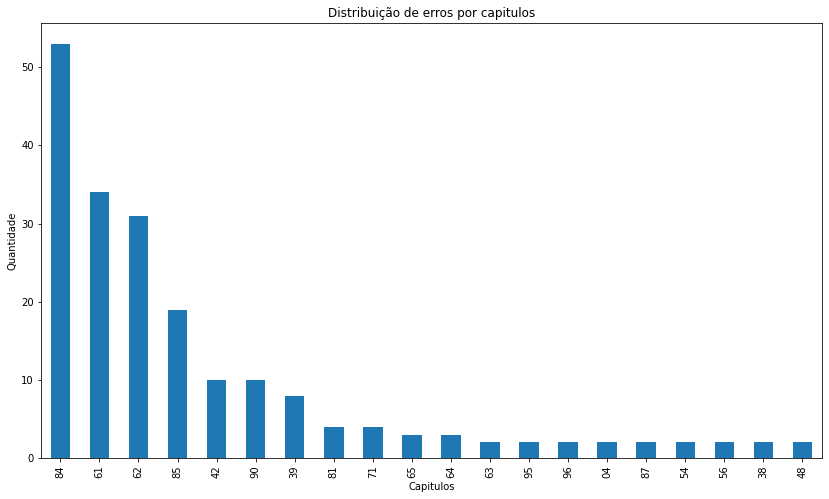

In [60]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[df_erros['capitulo'] != df_erros.cap_resul]
values = df_temp['cap_resul'].value_counts()
threshold = 1  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")
print(f"Quantidade de capítulos errados: {len(df_temp['cap_resul'].value_counts())}")

### 9.6 - Erros em posição - detalha quantidade de posições erradass e quantos erros por posição

In [61]:
total_err = {}
for posicao in posicoes_err:
    if total_err.get(posicao):
        total_err[posicao] += 1
    else:
        total_err[posicao] = 1

print(f'Total de posições erradas: {len(total_err.keys())}')
print(f'Total de erros em posiçõss: {len(posicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['posicao'] == str(k).zfill(2)])
    print(f'Posição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de posições erradas: 43
Total de erros em posiçõss: 468 erros

Posição com erro: 17 => 45 erro(s) em 2294 = 1.96%
Posição com erro: 26 => 15 erro(s) em 299 = 5.02%
Posição com erro: 36 => 2 erro(s) em 129 = 1.55%
Posição com erro: 82 => 7 erro(s) em 1258 = 0.56%
Posição com erro: 05 => 38 erro(s) em 820 = 4.63%
Posição com erro: 02 => 20 erro(s) em 1730 = 1.16%
Posição com erro: 19 => 3 erro(s) em 227 = 1.32%
Posição com erro: 07 => 19 erro(s) em 905 = 2.10%
Posição com erro: 14 => 73 erro(s) em 1513 = 4.82%
Posição com erro: 11 => 8 erro(s) em 412 = 1.94%
Posição com erro: 03 => 26 erro(s) em 2393 = 1.09%
Posição com erro: 77 => 3 erro(s) em 20 = 15.00%
Posição com erro: 06 => 28 erro(s) em 1261 = 2.22%
Posição com erro: 13 => 6 erro(s) em 275 = 2.18%
Posição com erro: 04 => 20 erro(s) em 2631 = 0.76%
Posição com erro: 10 => 23 erro(s) em 584 = 3.94%
Posição com erro: 18 => 3 erro(s) em 857 = 0.35%
Posição com erro: 01 => 9 erro(s) em 662 = 1.36%
Posição com erro: 09 => 13 erro(

Quantidade de posições erradas: 54


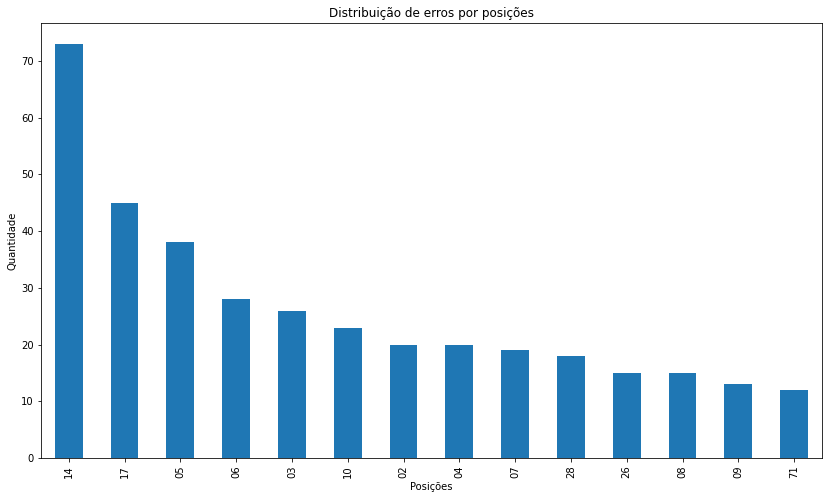

In [62]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                   (df_erros['posicao'] != df_erros.pos_resul)]
df_temp.head()
values = df_temp['pos_resul'].value_counts()
threshold = 10  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")
print(f"Quantidade de posições erradas: {len(df_temp['cap_resul'].value_counts())}")

### 9.7 - Erros em subposição, item e subitem - calcula o erro por categoria e a quantidade de erros em cada categoria

In [63]:
total_err = {}
for subposicao in subposicoes_err:
    if total_err.get(subposicao):
        total_err[subposicao] += 1
    else:
        total_err[subposicao] = 1

print(f'Total de subposições erradas: {len(total_err.keys())}')
print(f'Total de erros em subposiçõss: {len(subposicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subposicao'] == str(k).zfill(2)])
    print(f'Subposição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subposições erradas: 46
Total de erros em subposiçõss: 3257 erros

Subposição com erro: 51 => 29 erro(s) em 437 = 6.64%
Subposição com erro: 11 => 101 erro(s) em 507 = 19.92%
Subposição com erro: 50 => 197 erro(s) em 1001 = 19.68%
Subposição com erro: 10 => 38 erro(s) em 2516 = 1.51%
Subposição com erro: 31 => 63 erro(s) em 244 = 25.82%
Subposição com erro: 21 => 100 erro(s) em 974 = 10.27%
Subposição com erro: 63 => 27 erro(s) em 209 = 12.92%
Subposição com erro: 40 => 65 erro(s) em 824 = 7.89%
Subposição com erro: 42 => 39 erro(s) em 156 = 25.00%
Subposição com erro: 23 => 30 erro(s) em 106 = 28.30%
Subposição com erro: 53 => 15 erro(s) em 51 = 29.41%
Subposição com erro: 90 => 373 erro(s) em 2599 = 14.35%
Subposição com erro: 14 => 34 erro(s) em 64 = 53.12%
Subposição com erro: 12 => 79 erro(s) em 1280 = 6.17%
Subposição com erro: 43 => 77 erro(s) em 167 = 46.11%
Subposição com erro: 33 => 61 erro(s) em 141 = 43.26%
Subposição com erro: 20 => 157 erro(s) em 1580 = 9.94%
Sub

In [64]:
total_err = {}
for item in itens_err:
    if total_err.get(item):
        total_err[item] += 1
    else:
        total_err[item] = 1

print(f'Total de itens erradas: {len(total_err.keys())}')
print(f'Total de erros em itens: {len(itens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['item'] == str(k)])
    print(f'Itens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de itens erradas: 10
Total de erros em itens: 1340 erros

Itens com erro: 1 => 279 erro(s) em 4628 = 6.03%
Itens com erro: 9 => 650 erro(s) em 5782 = 11.24%
Itens com erro: 2 => 206 erro(s) em 1646 = 12.52%
Itens com erro: 0 => 64 erro(s) em 10731 = 0.60%
Itens com erro: 8 => 22 erro(s) em 135 = 16.30%
Itens com erro: 5 => 42 erro(s) em 336 = 12.50%
Itens com erro: 3 => 38 erro(s) em 1603 = 2.37%
Itens com erro: 4 => 26 erro(s) em 842 = 3.09%
Itens com erro: 6 => 5 erro(s) em 110 = 4.55%
Itens com erro: 7 => 8 erro(s) em 291 = 2.75%


In [65]:
total_err = {}
for subitem in subitens_err:
    if total_err.get(subitem):
        total_err[subitem] += 1
    else:
        total_err[subitem] = 1

print(f'Total de subitens erradas: {len(total_err.keys())}')
print(f'Total de erros em subitens: {len(subitens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subitem'] == str(k)])
    print(f'Subitens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subitens erradas: 9
Total de erros em subitens: 938 erros

Subitens com erro: 5 => 116 erro(s) em 140 = 82.86%
Subitens com erro: 9 => 351 erro(s) em 2595 = 13.53%
Subitens com erro: 0 => 67 erro(s) em 19432 = 0.34%
Subitens com erro: 1 => 191 erro(s) em 2109 = 9.06%
Subitens com erro: 7 => 46 erro(s) em 258 = 17.83%
Subitens com erro: 3 => 55 erro(s) em 343 = 16.03%
Subitens com erro: 2 => 77 erro(s) em 910 = 8.46%
Subitens com erro: 4 => 33 erro(s) em 191 = 17.28%
Subitens com erro: 6 => 2 erro(s) em 76 = 2.63%


In [66]:
for i, row in enumerate(df_erros.iloc[:,0]):
    if df_erros.iloc[i,1] != df_erros.iloc[i,6]:
        print(f'errou capítulo {df_erros.iloc[i,1]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,2] != df_erros.iloc[i,7]:
        print(f'errou posicao {df_erros.iloc[i,2]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,3] != df_erros.iloc[i,8]:
        print(f'errou subposicao {df_erros.iloc[i,3]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,4] != df_erros.iloc[i,9]:
        print(f'errou item {df_erros.iloc[i,4]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,5] != df_erros.iloc[i,10]:
        print(f'errou subitem {df_erros.iloc[i,5]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')

errou item 3 - ncm: 32199030 - ncm_resul= 32199010
errou posicao 04 - ncm: 85044010 - ncm_resul= 85174010
errou posicao 04 - ncm: 85044010 - ncm_resul= 85174010
errou posicao 17 - ncm: 85177099 - ncm_resul= 85269099
errou capítulo 95 - ncm: 95030031 - ncm_resul= 71171900
errou capítulo 85 - ncm: 85044010 - ncm_resul= 84044010
errou subposicao 10 - ncm: 39231090 - ncm_resul= 39235110
errou item 1 - ncm: 49111010 - ncm_resul= 49111090
errou posicao 20 - ncm: 39209990 - ncm_resul= 39365110
errou capítulo 91 - ncm: 91139000 - ncm_resul= 71139000
errou subitem 6 - ncm: 22041096 - ncm_resul= 22041095
errou capítulo 22 - ncm: 22041090 - ncm_resul= 71041090
errou posicao 03 - ncm: 95030021 - ncm_resul= 95820021
errou item 0 - ncm: 84807100 - ncm_resul= 84807122
errou item 9 - ncm: 84186999 - ncm_resul= 84186919
errou posicao 01 - ncm: 49019900 - ncm_resul= 49054010
errou posicao 04 - ncm: 64041100 - ncm_resul= 64021900
errou item 9 - ncm: 42021290 - ncm_resul= 42021210
errou item 9 - ncm: 4202

errou subposicao 83 - ncm: 03028320 - ncm_resul= 03028920
errou subposicao 84 - ncm: 03028400 - ncm_resul= 03028900
errou subposicao 85 - ncm: 03028500 - ncm_resul= 03028900
errou subitem 3 - ncm: 03028923 - ncm_resul= 03028921
errou subitem 4 - ncm: 03028924 - ncm_resul= 03028921
errou subitem 2 - ncm: 03028932 - ncm_resul= 03028931
errou subitem 3 - ncm: 03028933 - ncm_resul= 03028935
errou subitem 4 - ncm: 03028934 - ncm_resul= 03028935
errou subitem 6 - ncm: 03028936 - ncm_resul= 03028935
errou subitem 7 - ncm: 03028937 - ncm_resul= 03028935
errou subitem 8 - ncm: 03028938 - ncm_resul= 03028935
errou subitem 4 - ncm: 03028944 - ncm_resul= 03028943
errou subitem 5 - ncm: 03028945 - ncm_resul= 03028943
errou subposicao 11 - ncm: 03031100 - ncm_resul= 03031900
errou subposicao 13 - ncm: 03031300 - ncm_resul= 03031400
errou subposicao 19 - ncm: 03031900 - ncm_resul= 03038900
errou subposicao 23 - ncm: 03032300 - ncm_resul= 03033200
errou subposicao 24 - ncm: 03032410 - ncm_resul= 03033

errou subitem 3 - ncm: 29349123 - ncm_resul= 29349122
errou subitem 9 - ncm: 29349129 - ncm_resul= 29349122
errou subitem 1 - ncm: 29349131 - ncm_resul= 29349132
errou subitem 3 - ncm: 29349133 - ncm_resul= 29349132
errou subitem 1 - ncm: 29349141 - ncm_resul= 29349142
errou subitem 9 - ncm: 29349149 - ncm_resul= 29349142
errou item 5 - ncm: 29349150 - ncm_resul= 29349122
errou item 6 - ncm: 29349160 - ncm_resul= 29349122
errou item 7 - ncm: 29349170 - ncm_resul= 29349122
errou subitem 2 - ncm: 29349912 - ncm_resul= 29349911
errou subitem 6 - ncm: 29349926 - ncm_resul= 29349925
errou subitem 7 - ncm: 29349927 - ncm_resul= 29349925
errou subitem 9 - ncm: 29349929 - ncm_resul= 29349925
errou subitem 4 - ncm: 29349934 - ncm_resul= 29349939
errou item 6 - ncm: 29349961 - ncm_resul= 29349951
errou item 6 - ncm: 29349969 - ncm_resul= 29349949
errou subposicao 50 - ncm: 29355000 - ncm_resul= 29359090
errou subitem 3 - ncm: 29359013 - ncm_resul= 29359019
errou subitem 5 - ncm: 29359015 - ncm_r

errou item 0 - ncm: 38062000 - ncm_resul= 38062010
errou item 0 - ncm: 38063000 - ncm_resul= 38063090
errou subitem 9 - ncm: 38069019 - ncm_resul= 38069012
errou item 9 - ncm: 38069090 - ncm_resul= 38069010
errou subposicao 52 - ncm: 38085200 - ncm_resul= 38085900
errou subitem 0 - ncm: 38085910 - ncm_resul= 38085919
errou subitem 3 - ncm: 38085923 - ncm_resul= 38085920
errou item 2 - ncm: 38085929 - ncm_resul= 38085999
errou subposicao 61 - ncm: 38086100 - ncm_resul= 38085990
errou subposicao 62 - ncm: 38086210 - ncm_resul= 38085910
errou subposicao 62 - ncm: 38086290 - ncm_resul= 38085990
errou item 1 - ncm: 38086910 - ncm_resul= 38086990
errou subposicao 69 - ncm: 38086990 - ncm_resul= 38085990
errou subitem 3 - ncm: 38089193 - ncm_resul= 38089195
errou subitem 4 - ncm: 38089194 - ncm_resul= 38089197
errou subitem 6 - ncm: 38089196 - ncm_resul= 38089195
errou subitem 8 - ncm: 38089198 - ncm_resul= 38089195
errou subposicao 92 - ncm: 38089211 - ncm_resul= 38089411
errou subposicao 92

errou posicao 06 - ncm: 52061400 - ncm_resul= 52052300
errou subposicao 15 - ncm: 52061500 - ncm_resul= 52061400
errou posicao 06 - ncm: 52062200 - ncm_resul= 52052100
errou posicao 06 - ncm: 52062300 - ncm_resul= 52052310
errou posicao 06 - ncm: 52062400 - ncm_resul= 52052300
errou subposicao 25 - ncm: 52062500 - ncm_resul= 52061400
errou posicao 06 - ncm: 52063200 - ncm_resul= 52054200
errou posicao 06 - ncm: 52063300 - ncm_resul= 52053300
errou posicao 06 - ncm: 52063400 - ncm_resul= 52053300
errou subposicao 35 - ncm: 52063500 - ncm_resul= 52064200
errou subposicao 41 - ncm: 52064100 - ncm_resul= 52063100
errou posicao 06 - ncm: 52064200 - ncm_resul= 52054200
errou posicao 06 - ncm: 52064300 - ncm_resul= 52053300
errou posicao 06 - ncm: 52064400 - ncm_resul= 52053300
errou subposicao 45 - ncm: 52064500 - ncm_resul= 52064200
errou posicao 07 - ncm: 52079000 - ncm_resul= 52099000
errou subposicao 12 - ncm: 52081200 - ncm_resul= 52081100
errou posicao 08 - ncm: 52081300 - ncm_resul= 5

errou subitem 8 - ncm: 69021018 - ncm_resul= 69021019
errou item 1 - ncm: 69022010 - ncm_resul= 69022091
errou item 1 - ncm: 69029010 - ncm_resul= 69029090
errou item 4 - ncm: 69031040 - ncm_resul= 69031010
errou item 9 - ncm: 69031090 - ncm_resul= 69031010
errou item 2 - ncm: 69032020 - ncm_resul= 69032030
errou item 9 - ncm: 69039091 - ncm_resul= 69039011
errou subposicao 10 - ncm: 69041000 - ncm_resul= 69049000
errou subposicao 10 - ncm: 69051000 - ncm_resul= 69059000
errou subposicao 22 - ncm: 69072200 - ncm_resul= 69072100
errou subposicao 23 - ncm: 69072300 - ncm_resul= 69072100
errou subposicao 11 - ncm: 69091100 - ncm_resul= 69091990
errou item 1 - ncm: 69091210 - ncm_resul= 69091290
errou item 1 - ncm: 69091910 - ncm_resul= 69091990
errou subposicao 90 - ncm: 69099000 - ncm_resul= 69091990
errou subposicao 10 - ncm: 69101000 - ncm_resul= 69109000
errou subposicao 90 - ncm: 69119000 - ncm_resul= 69111000
errou posicao 12 - ncm: 69120000 - ncm_resul= 69119000
errou subposicao 10

errou subposicao 31 - ncm: 84623100 - ncm_resul= 84623910
errou item 1 - ncm: 84623910 - ncm_resul= 84623990
errou subposicao 41 - ncm: 84624100 - ncm_resul= 84623900
errou subposicao 49 - ncm: 84624900 - ncm_resul= 84623990
errou subposicao 91 - ncm: 84629119 - ncm_resul= 84629919
errou subposicao 91 - ncm: 84629191 - ncm_resul= 84629999
errou subposicao 91 - ncm: 84629199 - ncm_resul= 84629999
errou item 1 - ncm: 84629910 - ncm_resul= 84629990
errou item 2 - ncm: 84629920 - ncm_resul= 84629990
errou subitem 0 - ncm: 84629990 - ncm_resul= 84629999
errou item 1 - ncm: 84631010 - ncm_resul= 84631090
errou subposicao 10 - ncm: 84631090 - ncm_resul= 84639090
errou subposicao 20 - ncm: 84632099 - ncm_resul= 84639099
errou item 1 - ncm: 84639010 - ncm_resul= 84639099
errou subitem 0 - ncm: 84639090 - ncm_resul= 84639099
errou item 0 - ncm: 84641000 - ncm_resul= 84641010
errou item 2 - ncm: 84642029 - ncm_resul= 84642099
errou subitem 0 - ncm: 84642090 - ncm_resul= 84642099
errou item 1 - nc

errou subposicao 10 - ncm: 90111000 - ncm_resul= 90118000
errou item 1 - ncm: 90112010 - ncm_resul= 90112020
errou subposicao 10 - ncm: 90121010 - ncm_resul= 90129010
errou item 1 - ncm: 90131010 - ncm_resul= 90131090
errou subposicao 10 - ncm: 90131090 - ncm_resul= 90138090
errou item 1 - ncm: 90138010 - ncm_resul= 90138090
errou item 0 - ncm: 90139000 - ncm_resul= 90139090
errou subposicao 10 - ncm: 90141000 - ncm_resul= 90148000
errou item 1 - ncm: 90142010 - ncm_resul= 90142090
errou item 0 - ncm: 90149000 - ncm_resul= 90149090
errou subposicao 10 - ncm: 90151000 - ncm_resul= 90158000
errou subposicao 40 - ncm: 90154000 - ncm_resul= 90158090
errou subposicao 10 - ncm: 90171010 - ncm_resul= 90178010
errou subposicao 10 - ncm: 90171090 - ncm_resul= 90178090
errou subposicao 20 - ncm: 90172000 - ncm_resul= 90178090
errou item 2 - ncm: 90173020 - ncm_resul= 90173090
errou subposicao 11 - ncm: 90181100 - ncm_resul= 90181990
errou subposicao 12 - ncm: 90181290 - ncm_resul= 90181490
errou